In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
input_dir = "/Users/schidara/repos/learningrepos/makemore/"
names_file = "names.txt"

In [3]:
with open(input_dir+names_file, "r") as f:
    names_lines = f.readlines()

In [4]:
names_lines = [line.strip() for line in names_lines]

In [5]:
names_lines[:3]

['emma', 'olivia', 'ava']

### torch dtypes

In [6]:
a = torch.zeros(3,5)
a

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [7]:
a = torch.zeros(3, 5, dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

### data creation

Plan
1. Assume for the model that . is both the start string of the name and also the end string (This is required to enumerate the probabilities of bigrams and start and end chars of the names are necessary to be modelled)
2. create a 2X2 array of the bigram occurrence where the first index is the first word and second index the second word of the bigram

In [9]:
names_lines[:2]

['emma', 'olivia']

In [11]:
# all chars
chars = ['.']+sorted(list(set(''.join(names_lines))))
print(chars)
stoi = {char:i for i, char in enumerate(chars)}
print(stoi['z'])
print(stoi['a'])
print(stoi['.'])

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
26
1
0


In [12]:
itos = {i:s for s, i in stoi.items()}
assert itos[stoi['j']]=='j'

In [13]:
print(len(chars))

27


In [14]:
# Creating a bigram count table
Counts = torch.zeros(27, 27, dtype=torch.int32)

In [15]:
# Populating it with the bigram counts
for name in names_lines:
    mod_name = '.'+name+'.'
    for fl, ll in zip(mod_name, mod_name[1:]):
        Counts[stoi[fl], stoi[ll]] += 1

In [16]:
Counts

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

### Visualise the counts

In [17]:
Counts.shape

torch.Size([27, 27])

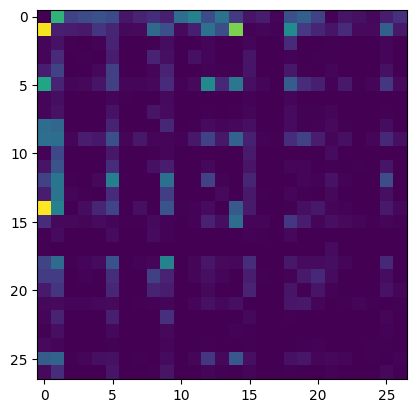

In [18]:
plt.imshow(Counts)

### Sampling from the model

In [20]:
Counts.dtype

torch.int32

In [23]:
Counts.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [24]:
# create the row sampling probabilities i.e. pmf for each row
probs = Counts.float()
probs /= probs.sum(1, keepdim=True)
assert probs[1].sum() == 1.0

In [28]:
probs[1,]

tensor([0.1960, 0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688,
        0.0487, 0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018,
        0.0963, 0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128])

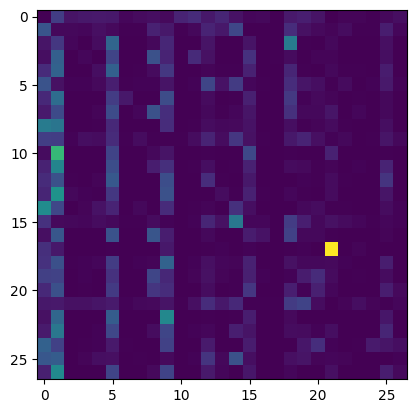

In [25]:
plt.imshow(probs)

In [26]:
probs[:, 0].sum()

tensor(3.0222)

In [27]:
probs[0, :].sum()

tensor(1.)

In [28]:
# We start with the . which is the starting char and end the sampling for the name after we encounter it another time
g = torch.Generator().manual_seed(1234)
curr_idx = stoi['.']
names = []
for num in range(20):
    name = ''
    while True:
        row_probs = probs[curr_idx]
        new_idx = torch.multinomial(row_probs, 1, replacement=True, generator=g).item()
        if new_idx == stoi['.']:
            break
        name += itos[new_idx]
        curr_idx = new_idx
    names.append(name)

print(names)

['d', 'eleeaccor', 'liah', '', 'in', '', 'ah', '', 'ahonyarefy', '', 'ibiey', 'n', 'isa', '', 'm', 'on', 'zliy', 'n', 'izay', 'naloule']


### Loss calculation on training set

In [29]:
def nll(likelihood):
    return -1*torch.log(likelihood)

In [30]:
c = 0
total_loss = 0
for num, name in enumerate(names_lines):
    name = '.' + name + '.'
    for fc, sc in zip(name, name[1:]):
        loss = nll(probs[stoi[fc], stoi[sc]])
        print(f"loss for {fc}, {sc} is {loss}")
        c += 1
        total_loss += loss
    break

loss for ., e is 3.0408456325531006
loss for e, m is 3.2793259620666504
loss for m, m is 3.6772043704986572
loss for m, a is 0.9417552351951599
loss for a, . is 1.629860520362854


In [31]:
print(f"The loss for a random model for generating a bigram is {nll(torch.tensor(1/27)):.4f}")
## So from the above emma example we got lower loss for a . example => it is a common structure in the data to end the name in a (more informative than a random bigram)

The loss for a random model for generating a bigram is 3.2958


In [32]:
c = 0
total_loss = 0
for num, name in enumerate(names_lines):
    name = '.' + name + '.'
    for fc, sc in zip(name, name[1:]):
        loss = nll(probs[stoi[fc], stoi[sc]])
        # print(f"loss for {fc}, {sc} is {loss}")
        c += 1
        total_loss += loss
print(f"average loss is {total_loss/c:0.4f}")

average loss is 2.4541


In [33]:
## compared to 3.29, 2.4 is lower.

## Neural Network Model

### data prep

In [34]:
# The network is set up to predict next word in all the bigrams. So the input data consists of the first char of the bigrams possible
# The output of the network is then the second words of the bigrams

xs, ys = [], []
for name in names_lines[:2]:
    name = '.' + name + '.'
    for fc, sc in zip(name, name[1:]):
        xi = stoi[fc]
        yi = stoi[sc]
        xs.append(xi)
        ys.append(yi)

In [35]:
xs, ys = torch.tensor(xs), torch.tensor(ys)
xs, ys

(tensor([ 0,  5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [36]:
xs.dtype

torch.int64

In [37]:
import torch.nn.functional as F

In [38]:
xs.shape

torch.Size([12])

In [39]:
xs[1]

tensor(5)

In [40]:
xs.dtype

torch.int64

In [41]:
# convert the xs to one hot encoding to be ready for applying further trnasformations
x_enc = F.one_hot(xs, num_classes=27).float()
x_enc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0

In [42]:
x_enc.shape

torch.Size([12, 27])

In [43]:
xs

tensor([ 0,  5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1])

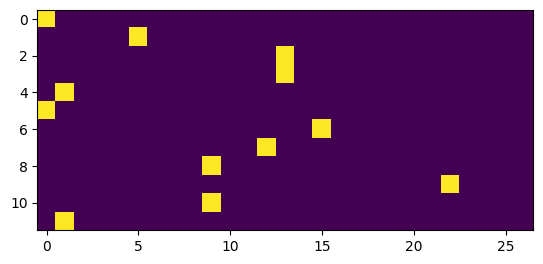

In [44]:
plt.imshow(x_enc)

### Network setup

In [45]:
# We now create the weight matrix for the first layer. Making the output layer to be of same size 27 so as to be able to convert to prob of sampling
g = torch.Generator().manual_seed(1234)
W = torch.randn(27, 27, generator=g, requires_grad=True)


In [46]:
W.grad = None
logits = x_enc @ W
logits.shape

torch.Size([12, 27])

In [47]:
logits[:, 0]

tensor([-0.1117, -1.5105, -1.8494, -1.8494,  0.2463, -0.1117, -1.2364, -1.6073,
         0.0124, -0.8842,  0.0124,  0.2463], grad_fn=<SelectBackward0>)

In [48]:
logits[2, :]

tensor([-1.8494, -1.2253, -0.6665, -0.5090, -0.5193,  0.4296, -1.3418, -0.3649,
         1.2697,  0.5690,  0.4715,  0.4616, -1.3822,  0.8789, -0.0990,  1.2043,
         0.1998, -0.0446, -0.2705,  1.1501,  1.4566,  2.7640, -0.3187, -0.1316,
        -0.6221, -1.4301, -1.4317], grad_fn=<SliceBackward0>)

In [49]:
logits.shape

torch.Size([12, 27])

In [50]:
print(logits.sum(1).shape)
print(logits.sum(0).shape)


torch.Size([12])
torch.Size([27])


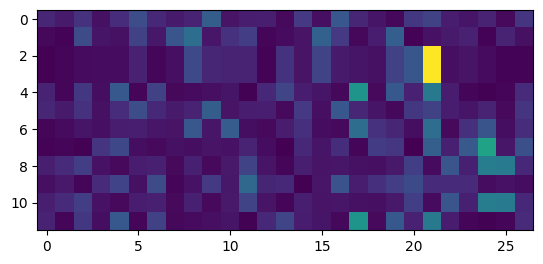

In [53]:
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
plt.imshow(probs.detach().numpy())

In [54]:
# Each row of the above logits corresponds to one sample in the training data of bigrams and represents the logits of the prediction
# The way to think of it as log(counts) where counts is a positive number representing some count of the corresponding prediction char
# The prob then is the ratio of the count of the predicted to the total
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
print(probs[0])
print(probs[0].sum())

tensor([0.0357, 0.0243, 0.0470, 0.0165, 0.0421, 0.0779, 0.0376, 0.0250, 0.0322,
        0.0967, 0.0187, 0.0276, 0.0284, 0.0098, 0.0550, 0.0144, 0.0888, 0.0364,
        0.0197, 0.0080, 0.0533, 0.0652, 0.0272, 0.0196, 0.0337, 0.0093, 0.0498],
       grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SumBackward0>)


In [55]:
probs.shape

torch.Size([12, 27])

### Loss calculation

In [57]:
probs_oned = probs[torch.arange(xs.shape[0]), ys]
loss = nll(probs_oned).mean()
print(loss)

tensor(3.6201, grad_fn=<MeanBackward0>)


In [58]:
# Loss is the nll of the predictions of the actual ys
losses = probs[np.arange(len(xs)), ys]
losses = nll(losses)
losses.shape

torch.Size([12])

In [59]:
loss = losses.mean()
loss.item()

3.62011456489563

### Backprop

In [60]:
loss.backward()

In [61]:
W.grad.shape

torch.Size([27, 27])

In [62]:
W.grad[0]

tensor([ 0.0060,  0.0041,  0.0078,  0.0028,  0.0070, -0.0703,  0.0063,  0.0042,
         0.0054,  0.0161,  0.0031,  0.0046,  0.0047,  0.0016,  0.0092, -0.0809,
         0.0148,  0.0061,  0.0033,  0.0013,  0.0089,  0.0109,  0.0045,  0.0033,
         0.0056,  0.0015,  0.0083])

In [63]:
W.data += -0.1 * W.grad

### Iteratable setup

In [64]:
len(stoi)

27

In [65]:
from bigram_network_train import make_input_output, BigramModel

In [66]:
import importlib

import bigram_network_train

In [67]:
# Reload the module
importlib.reload(bigram_network_train)

# Import the functions/classes again
from bigram_network_train import make_input_output, BigramModel


In [68]:
xs , ys, stoi, itos = make_input_output()
model = BigramModel(xs, ys, stoi, itos)
losses = model.run(10, 0.1)

In [69]:
losses

[3.8109018802642822,
 3.8100194931030273,
 3.809138298034668,
 3.808257818222046,
 3.8073787689208984,
 3.806499719619751,
 3.8056223392486572,
 3.8047454357147217,
 3.8038694858551025,
 3.8029944896698]

In [70]:
losses = model.run(10, 1)
losses

[3.8021202087402344,
 3.7934048175811768,
 3.7847745418548584,
 3.776228427886963,
 3.7677650451660156,
 3.759382724761963,
 3.7510814666748047,
 3.742859363555908,
 3.734715700149536,
 3.7266488075256348]

In [71]:
losses = model.run(10, 10)
losses

[3.7186594009399414,
 3.6412394046783447,
 3.570965051651001,
 3.507004737854004,
 3.4486145973205566,
 3.3951172828674316,
 3.3459038734436035,
 3.3004510402679443,
 3.25832200050354,
 3.21916127204895]

In [72]:
losses = model.run(10, 50)
losses

[3.1826820373535156,
 3.0249009132385254,
 2.915668249130249,
 2.8385655879974365,
 2.7824535369873047,
 2.740199327468872,
 2.7074239253997803,
 2.681370973587036,
 2.6602137088775635,
 2.6426966190338135]

In [151]:
losses = model.run(10, 100)
losses

[2.6279375553131104,
 2.603623628616333,
 2.58530330657959,
 2.5709047317504883,
 2.559258460998535,
 2.549635410308838,
 2.541548490524292,
 2.534660577774048,
 2.5287282466888428,
 2.523571252822876]

In [152]:
losses = model.run(100, 10)
losses[::10]

[2.519052505493164,
 2.5151607990264893,
 2.511686325073242,
 2.5085670948028564,
 2.505753755569458,
 2.5032031536102295,
 2.5008816719055176,
 2.4987587928771973,
 2.4968104362487793,
 2.4950151443481445]

In [153]:
losses = model.run(100, 1)
losses[::10]

[2.4933557510375977,
 2.493196725845337,
 2.49303936958313,
 2.49288272857666,
 2.492727518081665,
 2.4925732612609863,
 2.492420196533203,
 2.4922683238983154,
 2.4921176433563232,
 2.4919679164886475]

In [154]:
losses = model.run(100, 1)
losses[::10]

[2.491819143295288,
 2.4916718006134033,
 2.4915249347686768,
 2.491379499435425,
 2.4912352561950684,
 2.491091728210449,
 2.4909493923187256,
 2.4908080101013184,
 2.4906673431396484,
 2.490528106689453]

In [155]:
losses = model.run(300, 1)
losses[::10]

[2.490389585494995,
 2.4902524948120117,
 2.4901154041290283,
 2.4899799823760986,
 2.4898452758789062,
 2.489711284637451,
 2.4895787239074707,
 2.4894471168518066,
 2.4893157482147217,
 2.4891855716705322,
 2.489056348800659,
 2.4889278411865234,
 2.488800525665283,
 2.488673686981201,
 2.4885475635528564,
 2.4884228706359863,
 2.4882986545562744,
 2.4881751537323,
 2.4880523681640625,
 2.4879307746887207,
 2.487809658050537,
 2.487689256668091,
 2.487570285797119,
 2.4874510765075684,
 2.4873335361480713,
 2.4872162342071533,
 2.4870998859405518,
 2.4869840145111084,
 2.4868690967559814,
 2.4867546558380127]

In [156]:
model.sample(1)

['galtaia']

In [157]:
model.sample(10)

['xydlwiekkralmtedyo',
 'mtneba',
 'eha',
 'myd',
 'tenamnetralkdlyu',
 'eci',
 'iianejlneldhceeiwf',
 'jccix',
 'ceeealnaljnitaetrafneybald',
 'ddlkhlkrtemrykhsiaharahgia']

In [158]:
## TODO:
# 1. add regularisation
# 2. Move to gpu